In [11]:
from PIL import Image
from vangogh.evolution import Evolution
from vangogh.fitness import draw_voronoi_image
from vangogh.util import IMAGE_SHRINK_SCALE, REFERENCE_IMAGE
from IPython.display import display, clear_output
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.axes_grid1 import ImageGrid
plt.style.use('classic')
%matplotlib inline

from multiprocess import Pool, cpu_count

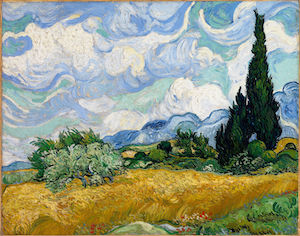

In [12]:
display(REFERENCE_IMAGE)

In [13]:
# Enable to show live rendering of best individual during optimization
display_output = False
# Enable to save progress images at every 50th generation
save_progress = True
# Enable to print verbose output per generation
verbose_output = True

In [14]:
def reporter(time, evo):
    if save_progress or display_output:
        elite = draw_voronoi_image(evo.elite, evo.reference_image.width, evo.reference_image.height, scale=IMAGE_SHRINK_SCALE)
    if display_output:
        clear_output()
        display(elite)
    if save_progress and time["num-generations"] % 50 == 0:
        elite.save(f"./img/van_gogh_intermediate_{evo.seed}_{evo.population_size}_{evo.crossover_method}_{evo.num_points}_{evo.initialization}_{evo.generation_budget}_{time['num-generations']:05d}.png")

def run_algorithm(settings):
    seed, population_size, crossover_method, num_points, initialization, generation_budget = settings
    start = time()
    
    data = []
    evo = Evolution(num_points,
                    REFERENCE_IMAGE,
                    population_size=population_size,
                    generation_reporter=reporter,
                    crossover_method=crossover_method,
                    seed=seed,
                    initialization=initialization,
                    generation_budget=generation_budget,
                    num_features_mutation_strength=.25,
                    selection_name='tournament_4',
                    verbose=verbose_output)
    data = evo.run()
    time_spent = time() - start
    print(f"Done: run {seed} - pop {population_size} - crossover {crossover_method} - num. points {num_points} - initialization {initialization} - in {int(time_spent)} seconds")
    
    return data

## Running a single instance

In [15]:
%%time
data = run_algorithm((0, 100, "ONE_POINT", 100, 'RANDOM', 500))

generation: 1 best fitness: 134707 avg. fitness: 143610.45
generation: 2 best fitness: 134273 avg. fitness: 139705.69
generation: 3 best fitness: 131336 avg. fitness: 136312.15
generation: 4 best fitness: 127039 avg. fitness: 134125.79
generation: 5 best fitness: 127039 avg. fitness: 131832.41
generation: 6 best fitness: 123294 avg. fitness: 129270.83
generation: 7 best fitness: 123294 avg. fitness: 127130.28
generation: 8 best fitness: 119067 avg. fitness: 125220.76
generation: 9 best fitness: 118781 avg. fitness: 123393.09
generation: 10 best fitness: 117737 avg. fitness: 121603.97
generation: 11 best fitness: 111216 avg. fitness: 119460.74
generation: 12 best fitness: 111130 avg. fitness: 117245.38
generation: 13 best fitness: 109959 avg. fitness: 114954.43
generation: 14 best fitness: 109789 avg. fitness: 112285.59
generation: 15 best fitness: 109710 avg. fitness: 110793.16
generation: 16 best fitness: 108645 avg. fitness: 110036.45
generation: 17 best fitness: 106170 avg. fitness:

## Running a sweep of settings

In [16]:
%%time

generation_budget = 500
 
data = []
for seed in range(3):
    for population_size in (100,):
        for crossover_method in ("ONE_POINT",):
            for initialization in ("RANDOM",):
                for num_points in (100,):
                    data.extend(run_algorithm((seed, population_size, crossover_method, num_points, initialization, generation_budget)))

generation: 1 best fitness: 134707 avg. fitness: 143610.45
generation: 2 best fitness: 134273 avg. fitness: 139705.69
generation: 3 best fitness: 131336 avg. fitness: 136312.15
generation: 4 best fitness: 127039 avg. fitness: 134125.79
generation: 5 best fitness: 127039 avg. fitness: 131832.41
generation: 6 best fitness: 123294 avg. fitness: 129270.83
generation: 7 best fitness: 123294 avg. fitness: 127130.28
generation: 8 best fitness: 119067 avg. fitness: 125220.76
generation: 9 best fitness: 118781 avg. fitness: 123393.09
generation: 10 best fitness: 117737 avg. fitness: 121603.97
generation: 11 best fitness: 111216 avg. fitness: 119460.74
generation: 12 best fitness: 111130 avg. fitness: 117245.38
generation: 13 best fitness: 109959 avg. fitness: 114954.43
generation: 14 best fitness: 109789 avg. fitness: 112285.59
generation: 15 best fitness: 109710 avg. fitness: 110793.16
generation: 16 best fitness: 108645 avg. fitness: 110036.45
generation: 17 best fitness: 106170 avg. fitness:

## Evaluating the results

In [17]:
df = pd.DataFrame(data)
df["time-elapsed"] = df["time-elapsed"].round(0)

In [18]:
# your plotting code here...

## Displaying the best instances over time

In [19]:
def show_progress_over_time(settings, selection=None, grid=(5,4)):
    seed, population_size, crossover_method, num_points, initialization, generation_budget = settings
    fig = plt.figure(figsize=(20., 20.))
    grid = ImageGrid(fig, 111, 
                     nrows_ncols=grid,
                     axes_pad=0.1,  # pad between axes
                     )

    if selection is None:
        selection = range(50, generation_budget + 50, 50)
    
    img_arr = [Image.open((f"./img/van_gogh_intermediate_{seed}_{population_size}_{crossover_method}_{num_points}_{initialization}_{generation_budget}_{i:05d}.png")) for i in selection]
    for ax, im in zip(grid, img_arr):
        ax.imshow(im)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

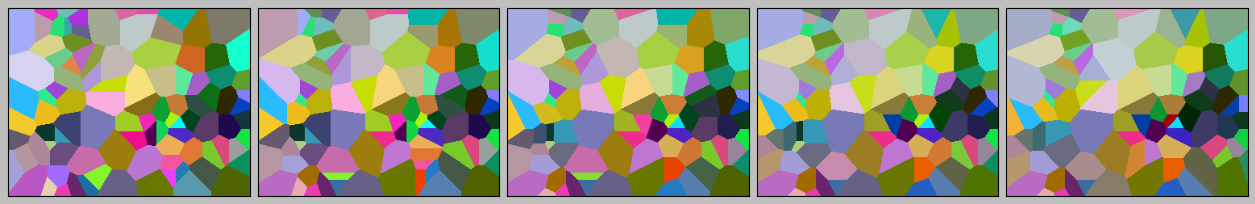

In [21]:
show_progress_over_time((0, 100, 'ONE_POINT', 100, "RANDOM", 500), grid=(1,5))